In [1]:
from datetime import datetime

# print date as date accessed
date_accessed = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Date accessed: {date_accessed}")

Date accessed: 2024-10-09 21:44:11


In [2]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

In [10]:
client.close()
cluster.close()

In [3]:
import dask
import dask.distributed as dd
if 'client' in locals():
    client.close()
    cluster.close()
cluster = dd.LocalCluster(n_workers=24, dashboard_address=8787)
client = dd.Client(cluster)

- One noticiable problem I encountered is loading all years dataset using mfdataset. 
- So, better read individual years, call velocity, and save that data into respective velocity.nc files

for year in range(2018,2025,1):
    files = sorted(glob.glob(f'data/profiler_request/{year}*'))
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', parallel=True,).velocity
    ds.to_netcdf(f'data/{year}_velocity.nc')
    print(f'{year} done')

In [4]:
files = sorted(glob.glob(f'data/*.nc'))
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', parallel=True).velocity
data = ds.sel(range=slice(100,500))
data

<xarray.DataArray 'velocity' (station: 18, time: 341703, range: 17)> Size: 418MB
dask.array<getitem, shape=(18, 341703, 17), dtype=float32, chunksize=(17, 52704, 17), chunktype=numpy.ndarray>
Coordinates:
  * station  (station) <U9 648B 'PROF_ALB2' 'PROF_ALBA' ... 'PROF_WEBS'
  * range    (range) int64 136B 100 125 150 175 200 225 ... 400 425 450 475 500
  * time     (time) datetime64[ns] 3MB 2018-01-01T00:05:00 ... 2024-06-30T23:...
Attributes:
    units:    knots

### Checking the number of missing values across years and locations using the average of 5th and 55th minutes as hourly data
- Also, the time instances for an hour are at 5th, 15th, 25th, 35th, 45th, and 55th minutes. They are average of 10 minutes data centered at these instances. 
- So, to get the 00 UTC data, we need to average the previous 55th and next 5th times .

In [18]:
print(len(hourly_data.time))
print(hourly_data.notnull().any(dim='range').sum(dim='time'))
print(hourly_data.isnull().all(dim='range').sum(dim='time'))
print((~(hourly_data.isnull().all(dim='range'))).sum(dim='time'))

8760
<xarray.DataArray 'velocity' (station: 17)> Size: 136B
array([8008, 6629, 8043, 7172, 6464, 1182, 3279, 8349, 8055,  599, 8462,
       6839, 7706, 3434, 8097, 7907, 6822])
Coordinates:
  * station  (station) <U9 612B 'PROF_REDH' 'PROF_ALBA' ... 'PROF_STAT'
<xarray.DataArray 'velocity' (station: 17)> Size: 136B
array([ 752, 2131,  717, 1588, 2296, 7578, 5481,  411,  705, 8161,  298,
       1921, 1054, 5326,  663,  853, 1938])
Coordinates:
  * station  (station) <U9 612B 'PROF_REDH' 'PROF_ALBA' ... 'PROF_STAT'
<xarray.DataArray 'velocity' (station: 17)> Size: 136B
array([8008, 6629, 8043, 7172, 6464, 1182, 3279, 8349, 8055,  599, 8462,
       6839, 7706, 3434, 8097, 7907, 6822])
Coordinates:
  * station  (station) <U9 612B 'PROF_REDH' 'PROF_ALBA' ... 'PROF_STAT'


In [29]:
for year in range(2018,2024,1):
    file = sorted(glob.glob(f'data/{year}_velocity.nc'))[0]
    ds = xr.open_dataset(file).velocity

    # Select data points at the 5th and 55th minute
    data_at_5th_min = ds.sel(time=ds.time.dt.minute == 5).sel(range=slice(100, 1000))
    data_at_55th_min = ds.sel(time=ds.time.dt.minute == 55).sel(range=slice(100, 1000))

    # Shift 5th minute data to align with the previous hour's 0th minute
    data_at_5th_min['time'] = data_at_5th_min.time - pd.Timedelta(minutes=5)
    # Shift 55th minute data to align with the next hour's 0th minute
    data_at_55th_min['time'] = data_at_55th_min.time + pd.Timedelta(minutes=5)

    # Combine the two, averaging where both exist
    stacked_data = xr.concat([data_at_5th_min, data_at_55th_min], dim='new') 
    hourly_data = xr.apply_ufunc(np.nanmean, stacked_data, input_core_dims=[['new']], kwargs={'axis': -1})
    
    # --- Find missing instances along the range dimension only if all of the vertical levels are missing
    missing_mask = hourly_data.isnull().all(dim='range')    # This is similary to the notnull().any(dim='range') mask, which is true if any vertical level is not null
    # Sum missing instances for each station along the time dimension
    missing_counts = missing_mask.sum(dim='time')
    not_missing_counts = (~missing_mask).sum(dim='time')
    # insted of printing, create a pandas dataframe with years as columns and stations as rows
    if year == 2018:
        df_all = pd.DataFrame(not_missing_counts.values*100/(len(hourly_data.time)), columns=[year], index=not_missing_counts.station.values)
    else:
        df_all[year] = not_missing_counts.values*100/(len(hourly_data.time))

    # ---Find missing instances along the range dimension if any of the vertical levels are missing
    missing_mask = hourly_data.isnull().any(dim='range') # This is similary to the notnull().all(dim='range') mask, which is true if all vertical level is not null
    # Sum missing instances for each station along the time dimension
    missing_counts = missing_mask.sum(dim='time')
    not_missing_counts = (~missing_mask).sum(dim='time')
    # insted of printing, create a pandas dataframe with years as columns and stations as rows
    if year == 2018:
        df_any = pd.DataFrame(not_missing_counts.values*100/(len(hourly_data.time)), columns=[year], index=not_missing_counts.station.values)
    else:
        df_any[year] = not_missing_counts.values*100/(len(hourly_data.time))

    # Criteria for missing data
    first_5_non_nan = hourly_data.sel(range=slice(100, 200)).notnull().sum(dim='range') >= 1
    last_5_non_nan = hourly_data.sel(range=slice(900, 1000)).notnull().sum(dim='range') >= 1
    intermediate_points = hourly_data.sel(range=slice(225, 875)).notnull().sum(dim='range') >= 25
    not_missing_mask = (first_5_non_nan & last_5_non_nan & intermediate_points)
    # Combine the criteria
    not_missing_counts = not_missing_mask.sum(dim='time')
    missing_counts = (~not_missing_mask).sum(dim='time')
    
    # insted of printing, create a pandas dataframe with years as columns and stations as rows
    if year == 2018:
        df_conditioned = pd.DataFrame(not_missing_counts.values*100/(len(hourly_data.time)), columns=[year], index=not_missing_counts.station.values)
    else:
        df_conditioned[year] = not_missing_counts.values*100/(len(hourly_data.time))

/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)


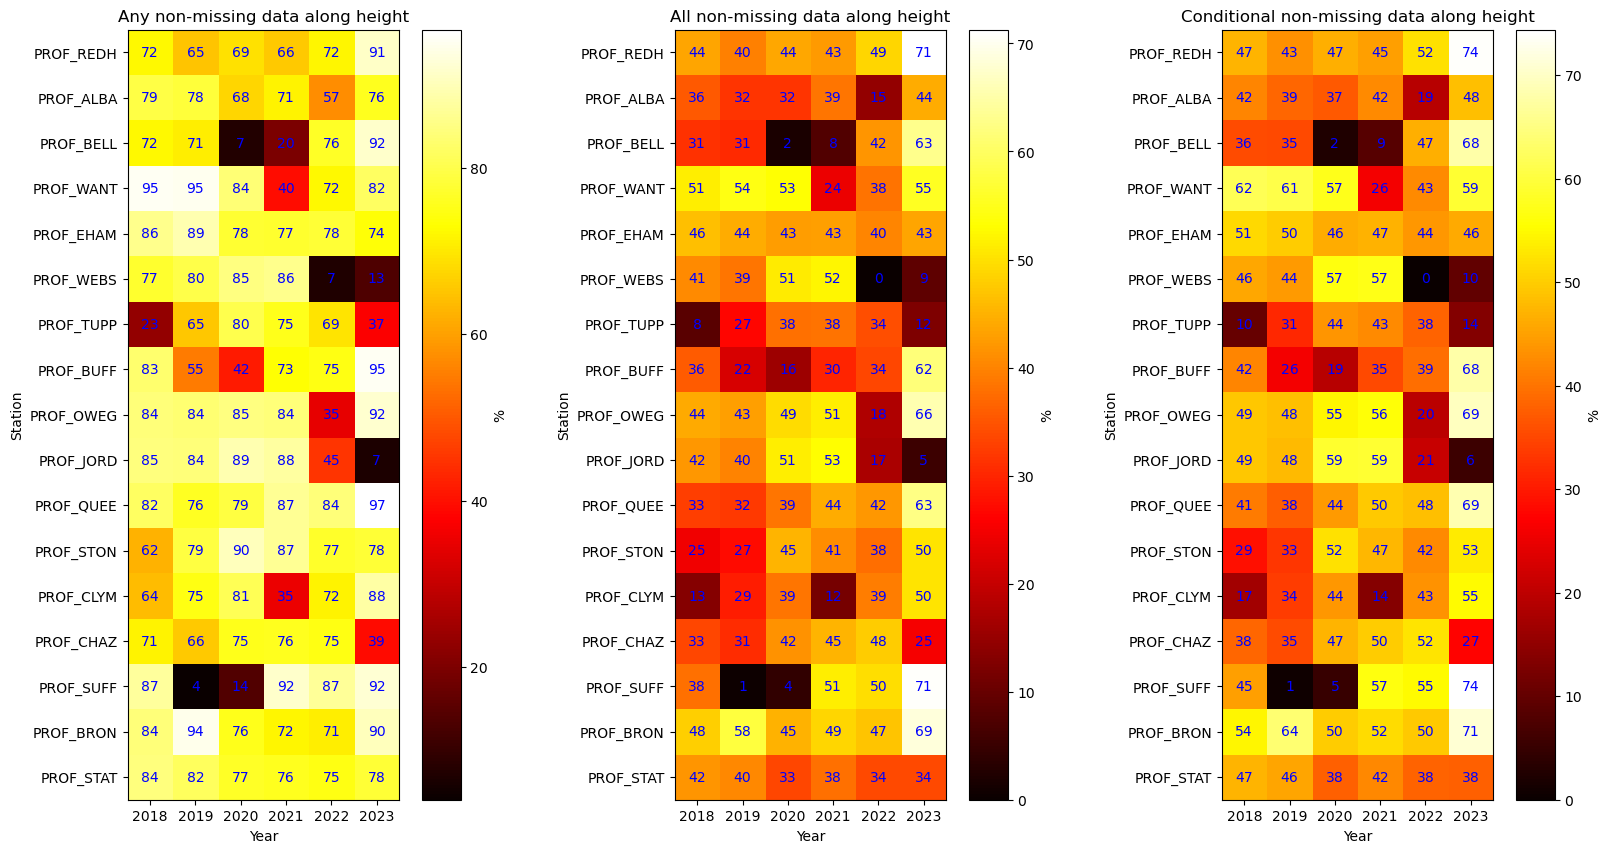

In [30]:
# now, plot a heatmap of the dataframe to visualize the missing data
plt.figure(figsize=(20,10))

# --- all missing data
plt.subplot(1,3,1)
plt.imshow(df_all, cmap='hot', interpolation='nearest')
# show values
for i in range(len(df_all.index)):
    for j in range(len(df_all.columns)):
        plt.text(j, i, round(df_all.values[i, j]), ha='center', va='center', color='blue')
plt.colorbar(label='%')
plt.title('Any non-missing data along height')
plt.xlabel('Year')
plt.ylabel('Station')
# set the x-axis labels to be the years and the y-axis labels to be the station numbers
plt.xticks(range(len(df_all.columns)), df_all.columns)
plt.yticks(range(len(df_all.index)), df_all.index)

# --- any missing data
plt.subplot(1,3,2)
plt.imshow(df_any, cmap='hot', interpolation='nearest')
# show values
for i in range(len(df_any.index)):
    for j in range(len(df_any.columns)):
        plt.text(j, i, round(df_any.values[i, j]), ha='center', va='center', color='blue')
plt.colorbar(label='%')
plt.title('All non-missing data along height')
plt.xlabel('Year')
plt.ylabel('Station')
# set the x-axis labels to be the years and the y-axis labels to be the station numbers
plt.xticks(range(len(df_any.columns)), df_any.columns)
plt.yticks(range(len(df_any.index)), df_any.index)

# --- conditional missing data
plt.subplot(1,3,3)
plt.imshow(df_conditioned, cmap='hot', interpolation='nearest')
# show values
for i in range(len(df_conditioned.index)):
    for j in range(len(df_conditioned.columns)):
        plt.text(j, i, round(df_conditioned.values[i, j]), ha='center', va='center', color='blue')
plt.colorbar(label='%')
plt.title('Conditional non-missing data along height')
plt.xlabel('Year')
plt.ylabel('Station')
# set the x-axis labels to be the years and the y-axis labels to be the station numbers
plt.xticks(range(len(df_conditioned.columns)), df_conditioned.columns)
plt.yticks(range(len(df_conditioned.index)), df_conditioned.index)

plt.show()